# Problem Statement

To build a machine learning model to classify whether a particular tweet is hate speech or not.

To create basic NLP based features that can be created from the text and then test the model on the test data set to evaluate it's performance.

# Work Flow

1. Data Collection -> involves dataset of Detecting Hate Speech in people's tweets
2. Data Analysis -> to understand the insights of the data, what is this data all about and other such kind of things
3. Data Cleaning ->  cleaning up the noise in the dataset
4. Feature Engineering -> creating numerical features that represent the underlying text
5. Data Splitting -> training data & test data
6. Model Building -> train an ML model for Text Classification
7. Model Evaluation -> Using the test data

# Data Collection

In [1]:
# importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# loading the dataset

data = pd.read_csv('C:/Users/K.KALYANKUMAR/OneDrive/Desktop/Project/Exploring Text Data/hate_speech_data.csv')
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


- **label** is the column that contains the target variable or the value that has to be predicted. 1 means it's a hate speech and 0 means it is not.
- **tweet** is the column that contains the text of the tweet. This is the main data on which NLP techniques will be applied.

# Data Analysis

In [3]:
data.shape

(5242, 3)

In [4]:
data.label.value_counts()

0    3000
1    2242
Name: label, dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5242 entries, 0 to 5241
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5242 non-null   int64 
 1   label   5242 non-null   int64 
 2   tweet   5242 non-null   object
dtypes: int64(2), object(1)
memory usage: 123.0+ KB


In [6]:
# checking for missing values in the dataset
data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [7]:
# having a close look at some of the tweets

for index, tweet in enumerate(data.tweet[10:15]):
    print(index+1, '.', tweet)

1 .  â #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in may   #blog #silver #gold #forex
2 . we are so selfish. #orlando #standwithorlando #pulseshooting #orlandoshooting #biggerproblems #selfish #heabreaking   #values #love #
3 . i get to see my daddy today!!   #80days #gettingfed
4 . ouch...junior is angryð#got7 #junior #yugyoem   #omg 
5 . i am thankful for having a paner. #thankful #positive     


# Data Cleaning

Noise present in Tweets

- many hashtags present in the tweets of the form '#' symbol followed by text. We particularly don't need the '#' symbol so we will clean it out.
- strange symbols like â and ð in tweet 4. This is actually unicode characters that is present in our dataset that we need to get rid of because they don't particularly add anything meaningful.
- numerals and percentages .

In [8]:
# cleaning up the noise in our dataset
import re

def clean_text(text):
    
    # Filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    # Removing Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    #Convert to lowercase to maintain consistency
    text = text.lower()
       
    return text

In [9]:
data['clean_text'] = data.tweet.apply(lambda x: clean_text(x))

In [10]:
data.head()

,id,label,tweet,clean_text
0,1,0,@user when a father is dysfunctional and is s...,user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...,user user thanks for lyft credit i can't us...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide society now motivation


# Feature Engineering

In [11]:
# Exhaustive list of stopwords in the english language.
import nltk
from nltk.corpus import stopwords

STOP_WORDS = set(stopwords.words('english'))
print(STOP_WORDS)

{'doing', 'few', 'mustn', 'am', "wouldn't", 'hadn', 'where', 'now', 'both', 'does', 'there', 'by', 'couldn', 'your', 'any', 'didn', 'herself', 'nor', "won't", 'because', "should've", 'these', 'while', 'those', 'but', 'will', 'only', 'just', 'with', 'yourselves', 'doesn', 're', 'above', 'an', 'ain', "shan't", 'don', 'most', 'over', 'own', 'aren', 'up', 'haven', 'below', 'whom', 'how', 's', 'himself', 'same', "weren't", 'what', "haven't", "couldn't", 'more', 'won', 'you', 'as', "didn't", 'her', 'themselves', 'd', 'from', "that'll", 't', 'further', 'they', 'isn', 'were', 'their', 'being', 'again', "mustn't", 'his', 'in', 've', 'then', 'into', 'wouldn', 'y', "you've", 'hers', 'was', 'having', "hasn't", 'until', 'on', 'ourselves', 'yourself', "she's", 'yours', 'here', 'each', "needn't", 'myself', 'the', 'or', "it's", 'so', 'shan', 'him', "you'd", 'a', "aren't", 'during', "hadn't", 'this', 'be', 'and', "you're", 'theirs', "don't", 'i', 'had', 'll', 'should', "mightn't", 'did', 'its', "isn't"

In [12]:
# Generating word frequency

def gen_freq(text):
    
    word_list = []

    # Loop over all the tweets and extract words into word_list
    for tw_words in text.split():
        word_list.extend(tw_words)

    # Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()
    
    # Drop the stopwords during the frequency calculation
    word_freq = word_freq.drop(STOP_WORDS, errors='ignore')
    
    return word_freq

In [13]:
# Checking whether a negation term is present in the text

def any_neg(words):
    
    for word in words:
        if word in ['n', 'no', 'non', 'not'] or re.search(r"\wn't", word):
            return 1
    else:
        return 0

In [14]:
# Checking whether one of the 100 rare words is present in the text

def any_rare(words, rare_100):
    
    for word in words:
        if word in rare_100:
            return 1
    else:
        return 0

In [15]:
# Checking whether prompt words are present

def is_question(words):
    
    for word in words:
        if word in ['when', 'what', 'how', 'why', 'who']:
            return 1
    else:
        return 0

In [16]:
word_freq = gen_freq(data.clean_text.str)

# 100 most rare words in the dataset
rare_100 = word_freq[-100:]

**Creating new features**

In [17]:
# Number of words in a tweet
data['word_count'] = data.clean_text.str.split().apply(lambda x: len(x))

# Negation present or not
data['any_neg'] = data.clean_text.str.split().apply(lambda x: any_neg(x))  

# Prompt present or not
data['is_question'] = data.clean_text.str.split().apply(lambda x: is_question(x))

# Any of the most 100 rare words present or not
data['any_rare'] = data.clean_text.str.split().apply(lambda x: any_rare(x, rare_100))

# Character count of the tweet
data['char_count'] = data.clean_text.apply(lambda x: len(x))

In [18]:
data.head()

,id,label,tweet,clean_text,word_count,any_neg,is_question,any_rare,char_count
0,1,0,@user when a father is dysfunctional and is s...,user when a father is dysfunctional and is s...,18,0,1,0,102
1,2,0,@user @user thanks for #lyft credit i can't us...,user user thanks for lyft credit i can't us...,19,1,0,0,122
2,3,0,bihday your majesty,bihday your majesty,3,0,0,0,21
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ...,12,0,0,0,86
4,5,0,factsguide: society now #motivation,factsguide society now motivation,4,0,0,0,39


In [19]:
data.tail()

,id,label,tweet,clean_text,word_count,any_neg,is_question,any_rare,char_count
5237,31935,1,lady banned from kentucky mall. @user #jcpenn...,lady banned from kentucky mall user jcpenn...,8,0,0,0,59
5238,31947,1,@user omfg i'm offended! i'm a mailbox and i'...,user omfg i'm offended i'm a mailbox and i'...,12,0,0,0,82
5239,31948,1,@user @user you don't have the balls to hashta...,user user you don't have the balls to hashta...,23,1,0,1,112
5240,31949,1,"makes you ask yourself, who am i? then am i a...",makes you ask yourself who am i then am i a...,17,0,1,0,87
5241,31961,1,"@user #sikh #temple vandalised in in #calgary,...",user sikh temple vandalised in in calgary ...,10,0,0,0,67


In [20]:
# Top 10 common words are
gen_freq(data.clean_text.str)[:10]

user      3351
amp        439
love       320
day        254
like       247
trump      214
happy      207
people     186
new        171
u          158
dtype: int64

# Data Splitting

- The dataset is split into train and test sets so that we can evaluate our model's performance on unseen data.
- The model will only be trained on the train set and will make predictions on the test set whose data points the model has never seen. This will make sure that we have a proper way to test the model.

In [21]:
x = data[['word_count', 'any_neg', 'is_question', 'any_rare', 'char_count']]
y = data.label

In [22]:
# Splitting into training data & test data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=27)

In [23]:
print(x.shape, x_train.shape, x_test.shape)

(5242, 5) (4717, 5) (525, 5)


# Logistic Regression

**Model Building**

In [24]:
# loading the logistic regression model
from sklearn.linear_model import LogisticRegression

model_logistic_reg  = LogisticRegression().fit(x_train, y_train)

In [25]:
# accuracy of training data
from sklearn.metrics import accuracy_score

x_train_log = model_logistic_reg.predict(x_train)
training_accuracy_log = accuracy_score(x_train_log, y_train)
training_accuracy_log

0.584693661225355

**Model Evaluation**

Evaluation Metrics
- Accuracy Score – no. of correctly classified instances/total no. of instances
- Precision Score – the ratio of correctly predicted instances over total positive instances
- Recall Score – the ratio of correctly predicted instances over total instances in that class
- Roc Curve – a plot of true positive rate against false positive rate
- Confusion Matrix – a table used to describe the classification models

In [26]:
# accuracy of test data

x_test_log = model_logistic_reg.predict(x_test)
test_accuracy_log = accuracy_score(x_test_log, y_test)
test_accuracy_log

0.5904761904761905

In [27]:
# confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, x_test_log)

array([[271,  39],
       [176,  39]], dtype=int64)

In [28]:
# import accuracy_score, precision_score, recall_score, f1_score from scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score

# Computing the accuracy, precision, recall and F1 scores of the model using your test data 'y_test' 
print('Accuracy score: ', format(accuracy_score(y_test, x_test_log)))
print('Precision score: ', format(precision_score(y_test, x_test_log)))
print('Recall score: ', format(recall_score(y_test, x_test_log)))
print('F1 score: ', format(f1_score(y_test, x_test_log)))

Accuracy score:  0.5904761904761905
Precision score:  0.5
Recall score:  0.1813953488372093
F1 score:  0.26621160409556316


we notice that for Logistic Regression Model the classification accuracy and f1 scores aren't that impressive. Hence we go for other models

**ROC Curve**

In [29]:
# probability of the class using the predict_proba()
predictions_probability = model_logistic_reg.predict_proba(x_test)

from sklearn.metrics import roc_auc_score
print("roc_auc_score: ",format(roc_auc_score(y_test, predictions_probability[:,1])))

roc_auc_score:  0.6160615153788448


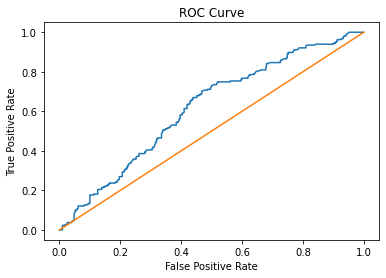

In [30]:
# ROC Curve
from sklearn.metrics import roc_curve

fpr,tpr,thresholds = roc_curve(y_test, predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

As we can see that our Logistic Regression model not performing well in detecting the hate speech, with an Accuracy score, Precision and Recall of approx **59%**. And the roc curve and confusion matrix are not good as well which means that our model is not able to classify the labels accurately.

# Naive Bayes Classifier

**Model Building**

In [31]:
# Loading Naive Bayes Model
from sklearn.naive_bayes import GaussianNB

model_naive = GaussianNB().fit(x_train,y_train)

In [32]:
# accuracy of training data

x_train_nb = model_naive.predict(x_train)
training_accuracy_nb = accuracy_score(x_train_nb, y_train)
training_accuracy_nb

0.44583421666313333

**Model Evaluation**

In [33]:
# accuracy of test data

x_test_nb = model_naive.predict(x_test)
test_accuracy_nb = accuracy_score(x_test_nb, y_test)
test_accuracy_nb

0.44

In [34]:
# confusion matrix
confusion_matrix(y_test, x_test_nb)

array([[ 23, 287],
       [  7, 208]], dtype=int64)

In [35]:
# Computing the accuracy, precision, recall and F1 scores of the model using your test data 'y_test' 
print('Accuracy score: ', format(accuracy_score(y_test, x_test_nb)))
print('Precision score: ', format(precision_score(y_test, x_test_nb)))
print('Recall score: ', format(recall_score(y_test, x_test_nb)))
print('F1 score: ', format(f1_score(y_test, x_test_nb)))

Accuracy score:  0.44
Precision score:  0.4202020202020202
Recall score:  0.9674418604651163
F1 score:  0.5859154929577465


we notice that for Naive Bayes Model also, the classification accuracy and f1 scores aren't that impressive. Hence we go for other models

**ROC Curve**

In [36]:
# probability of the class using the predict_proba()
predictions_probability = model_naive.predict_proba(x_test)
print("roc_auc_score: ",format(roc_auc_score(y_test, predictions_probability[:,1])))

roc_auc_score:  0.6238934733683421


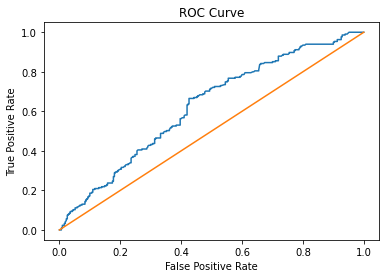

In [37]:
# ROC Curve
fpr,tpr,thresholds = roc_curve(y_test, predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

As we can see that our Naive Bayes model not good in detecting the hate speech, with an Accuracy score, Precision and Recall of approx **44%**. And the roc curve and confusion matrix are not good as well which means that Naive Bayes is not able to classify the labels accurately.

# Support Vector Machine Classifier

**Model Building**

In [38]:
# Loading Support Vector Machine Model
from sklearn import svm

model_svm = svm.SVC(kernel='linear').fit(x_train,y_train)

In [39]:
# accuracy of training data

x_train_svm = model_svm.predict(x_train)
training_accuracy_svm = accuracy_score(x_train_svm, y_train)
training_accuracy_svm

0.584693661225355

**Model Evaluation**

In [40]:
# accuracy of test data

x_test_svm = model_svm.predict(x_test)
test_accuracy_svm = accuracy_score(x_test_svm, y_test)
test_accuracy_svm

0.5980952380952381

In [41]:
# confusion matrix
confusion_matrix(y_test, x_test_svm)

array([[281,  29],
       [182,  33]], dtype=int64)

In [42]:
# Computing the accuracy, precision, recall and F1 scores of the model using your test data 'y_test' 
print('Accuracy score: ', format(accuracy_score(y_test, x_test_svm)))
print('Precision score: ', format(precision_score(y_test, x_test_svm)))
print('Recall score: ', format(recall_score(y_test, x_test_svm)))
print('F1 score: ', format(f1_score(y_test, x_test_svm)))

Accuracy score:  0.5980952380952381
Precision score:  0.532258064516129
Recall score:  0.15348837209302327
F1 score:  0.23826714801444046


As we can see that our SVM Classifier model is not performed good in detecting the hate speech, with an Accuracy score, Precision and Recall of approx **60%**.

# KNN Classifier

**Model Building**

In [43]:
# importing the K neighbors classifier
from sklearn.neighbors import KNeighborsClassifier

# Create the classifier
model_knn = KNeighborsClassifier(n_neighbors=5)

# fit the training data into the classifier
model_knn.fit(x_train, y_train)

pred_train_knn = model_knn.predict(x_train)
training_accuracy_knn = accuracy_score(pred_train_knn, y_train)
training_accuracy_knn

0.7150731397074411

In [44]:
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV 

parameters = [{'n_neighbors':[3,4,5,6,7,8,9,10,11,12,13,14,15]}]
search = GridSearchCV(model_knn, parameters, scoring='accuracy', cv=5, verbose=True).fit(x_train,y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    1.7s finished


In [45]:
# optimum parameter values
search.best_params_

{'n_neighbors': 12}

In [46]:
model_knn = KNeighborsClassifier(n_neighbors=12).fit(x_train, y_train)

In [47]:
# accuracy of training data

pred_train_knn = model_knn.predict(x_train)
training_accuracy_knn = accuracy_score(pred_train_knn, y_train)
training_accuracy_knn

0.676065295738817

**Model Evaluation**

In [48]:
# accuracy of test data

pred_test_knn = model_knn.predict(x_test)
test_accuracy_knn = accuracy_score(pred_test_knn, y_test)
test_accuracy_knn

0.6685714285714286

In [49]:
# confusion matrix
confusion_matrix(y_test, pred_test_knn)

array([[256,  54],
       [120,  95]], dtype=int64)

In [50]:
# Computing the accuracy, precision, recall and F1 scores of the model using your test data 'y_test' 
print('Accuracy score: ', format(accuracy_score(y_test, pred_test_knn)))
print('Precision score: ', format(precision_score(y_test, pred_test_knn)))
print('Recall score: ', format(recall_score(y_test, pred_test_knn)))
print('F1 score: ', format(f1_score(y_test, pred_test_knn)))

Accuracy score:  0.6685714285714286
Precision score:  0.6375838926174496
Recall score:  0.4418604651162791
F1 score:  0.521978021978022


**ROC Curve**

In [51]:
# probability of the class using the predict_proba()
predictions_probability = model_knn.predict_proba(x_test)
print("roc_auc_score: ",format(roc_auc_score(y_test, predictions_probability[:,1])))

roc_auc_score:  0.7237884471117779


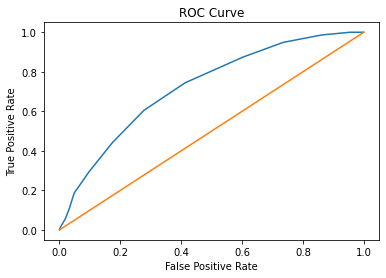

In [52]:
# ROC Curve
fpr,tpr,thresholds = roc_curve(y_test, predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

As we can see that our KNN Classifier model is somewat better than the previous models in detecting the hate speech, with an Accuracy score, Precision and Recall of approx **67%**. And the roc curve and confusion matrix are also better as well which means that KNN model is somewhat able to classify the labels accurately,  with some chances of error.

# Decision Tree Classifier

**Model Building**

In [53]:
# importing the Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
model_tree = DecisionTreeClassifier()

# fit the training data into the classifier
model_tree.fit(x_train, y_train)

pred_train_tree = model_tree.predict(x_train)
training_accuracy_tree = accuracy_score(pred_train_tree, y_train)
training_accuracy_tree

0.7941488234047064

In [54]:
# optimizing model parameters
from sklearn.model_selection import GridSearchCV   

parameters = [{'criterion':['gini','entropy']}]
search = GridSearchCV(model_tree, parameters, scoring='accuracy', cv=5, verbose=True, n_jobs=-1).fit(x_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished


In [55]:
# optimum parameter values
search.best_params_

{'criterion': 'entropy'}

In [56]:
model_tree = DecisionTreeClassifier(criterion='entropy').fit(x_train, y_train)

In [57]:
# accuracy of training data

pred_train_tree = model_tree.predict(x_train)
training_accuracy_tree = accuracy_score(pred_train_tree, y_train)
training_accuracy_tree

0.7941488234047064

**Model Evaluation**

In [58]:
# accuracy of test data

pred_test_tree = model_tree.predict(x_test)
test_accuracy_tree = accuracy_score(pred_test_tree, y_test)
test_accuracy_tree

0.638095238095238

In [59]:
# confusion matrix
confusion_matrix(y_test, pred_test_tree)

array([[233,  77],
       [113, 102]], dtype=int64)

In [60]:
# Computing the accuracy, precision, recall and F1 scores of the model using your test data 'y_test' 
print('Accuracy score: ', format(accuracy_score(y_test, pred_test_tree)))
print('Precision score: ', format(precision_score(y_test, pred_test_tree)))
print('Recall score: ', format(recall_score(y_test, pred_test_tree)))
print('F1 score: ', format(f1_score(y_test, pred_test_tree)))

Accuracy score:  0.638095238095238
Precision score:  0.5698324022346368
Recall score:  0.4744186046511628
F1 score:  0.517766497461929


**ROC Curve**

In [61]:
# probability of the class using the predict_proba()
predictions_probability = model_tree.predict_proba(x_test)
print("roc_auc_score: ",format(roc_auc_score(y_test, predictions_probability[:,1])))

roc_auc_score:  0.6589947486871718


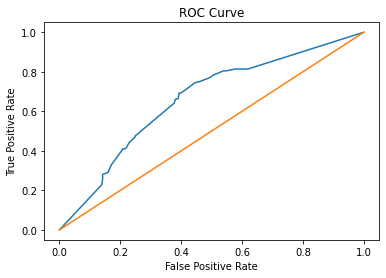

In [62]:
# ROC Curve
fpr,tpr,thresholds = roc_curve(y_test, predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

As we can see that our Decision Tree Classifier model not good in detecting the hate speech, with an Accuracy score, Precision and Recall of approx **64%**. And the roc curve and confusion matrix are not good as well which means that Decision Tree model is not able to classify the labels accurately.

# Random Forest

**Model Building**

In [63]:
# importing the Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

# Create the classifier
model_rf = RandomForestClassifier(n_estimators=500, max_features='sqrt')

# fit the training data into the classifier
model_rf.fit(x_train, y_train)

pred_train_rf = model_rf.predict(x_train)
training_accuracy_rf = accuracy_score(pred_train_rf, y_train)
training_accuracy_rf

0.7941488234047064

In [64]:
# optimizing model parameters

parameters = [{'criterion':['gini','entropy'], 'n_estimators':[100,200,300,400,500,600]}]
search = GridSearchCV(model_rf, parameters, scoring='accuracy', cv=5, verbose=True, n_jobs=-1).fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   30.7s finished


In [65]:
# optimum parameter values
search.best_params_

{'criterion': 'entropy', 'n_estimators': 200}

In [66]:
model_rf = RandomForestClassifier(criterion='entropy', n_estimators=200, max_features='sqrt').fit(x_train, y_train)

In [67]:
# accuracy of training data

pred_train_rf = model_rf.predict(x_train)
training_accuracy_rf = accuracy_score(pred_train_rf, y_train)
training_accuracy_rf

0.7941488234047064

**Model Evaluation**

In [68]:
# accuracy of test data

pred_test_rf = model_rf.predict(x_test)
test_accuracy_rf = accuracy_score(pred_test_rf, y_test)
test_accuracy_rf

0.6438095238095238

In [69]:
# confusion matrix
confusion_matrix(y_test, pred_test_rf)

array([[221,  89],
       [ 98, 117]], dtype=int64)

In [70]:
# Computing the accuracy, precision, recall and F1 scores of the model using your test data 'y_test' 
print('Accuracy score: ', format(accuracy_score(y_test, pred_test_rf)))
print('Precision score: ', format(precision_score(y_test, pred_test_rf)))
print('Recall score: ', format(recall_score(y_test, pred_test_rf)))
print('F1 score: ', format(f1_score(y_test, pred_test_rf)))

Accuracy score:  0.6438095238095238
Precision score:  0.5679611650485437
Recall score:  0.5441860465116279
F1 score:  0.5558194774346793


**ROC Curve**

In [71]:
# probability of the class using the predict_proba()
predictions_probability = model_rf.predict_proba(x_test)
print("roc_auc_score: ",format(roc_auc_score(y_test, predictions_probability[:,1])))

roc_auc_score:  0.7052213053263316


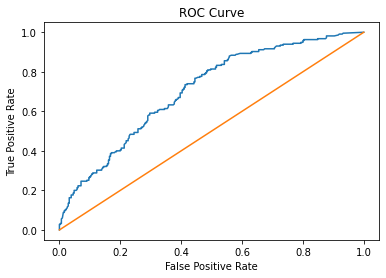

In [72]:
# ROC Curve
fpr,tpr,thresholds = roc_curve(y_test, predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

As we can see that our Random Forest Classifier model not good in detecting the hate speech, with an Accuracy score, Precision and Recall of approx **64%**. And the roc curve and confusion matrix are not good as well which means that Random Forest model is not able to classify the labels accurately.

# Bagging

**Model Building**

In [73]:
# Create the classifier
model_bag = RandomForestClassifier(n_estimators=500, max_features=None)

# fit the training data into the classifier
model_bag.fit(x_train, y_train)

pred_train_bag = model_bag.predict(x_train)
training_accuracy_bag = accuracy_score(pred_train_bag, y_train)
training_accuracy_bag

0.7941488234047064

In [74]:
# optimizing model parameters

parameters = [{'criterion':['gini','entropy'], 'n_estimators':[100,200,300,400,500,600]}]
search = GridSearchCV(model_bag, parameters, scoring='accuracy', cv=5, verbose=True, n_jobs=-1).fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   44.0s finished


In [75]:
# optimum parameter values
search.best_params_

{'criterion': 'gini', 'n_estimators': 200}

In [76]:
model_bag = RandomForestClassifier(criterion='gini', n_estimators=200, max_features=None).fit(x_train, y_train)

In [77]:
# accuracy of training data

pred_train_bag = model_bag.predict(x_train)
training_accuracy_bag = accuracy_score(pred_train_bag, y_train)
training_accuracy_bag

0.7941488234047064

**Model Evaluation**

In [78]:
# accuracy of test data

pred_test_bag = model_bag.predict(x_test)
test_accuracy_bag = accuracy_score(pred_test_bag, y_test)
test_accuracy_bag

0.6476190476190476

In [79]:
# confusion matrix
confusion_matrix(y_test, pred_test_bag)

array([[222,  88],
       [ 97, 118]], dtype=int64)

In [80]:
# Computing the accuracy, precision, recall and F1 scores of the model using your test data 'y_test' 
print('Accuracy score: ', format(accuracy_score(y_test, pred_test_bag)))
print('Precision score: ', format(precision_score(y_test, pred_test_bag)))
print('Recall score: ', format(recall_score(y_test, pred_test_bag)))
print('F1 score: ', format(f1_score(y_test, pred_test_bag)))

Accuracy score:  0.6476190476190476
Precision score:  0.5728155339805825
Recall score:  0.5488372093023256
F1 score:  0.5605700712589072


**ROC Curve**

In [81]:
# probability of the class using the predict_proba()
predictions_probability = model_bag.predict_proba(x_test)
print("roc_auc_score: ",format(roc_auc_score(y_test, predictions_probability[:,1])))

roc_auc_score:  0.7100975243810953


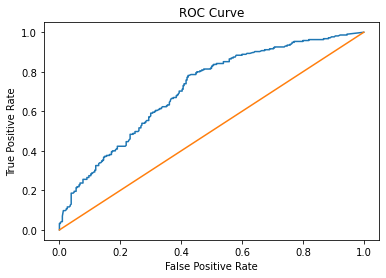

In [82]:
# ROC Curve
fpr,tpr,thresholds = roc_curve(y_test, predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

As we can see that our Bagging model not good in detecting the hate speech, with an Accuracy score, Precision and Recall of approx **65%**. And the roc curve and confusion matrix are not good as well which means that Bagging model is not able to classify the labels accurately.

# Comparison

Decreasing order of accuracy is depicted as:
- KNN Classifier - 0.6685
- Bagging - 0.6476
- Random Frest - 0.6438
- Decision Tree - 0.6380
- SVM Classifier - 0.5980
- Logistic Regression - 0.5904
- Naive Bayes - 0.44

The results are highly clear that more or less all the models are OK. KNN Classifier is the better one among all the models because its ability to handle an extremely large number of features. In our case, for each feature and there are number of different values. 

# Predicting for Custom Input:

In [83]:
# input data -> (word_count: 12, any_neg: 0, is_question: 0, any_rare:0, char_count:86) 
# output -> 0

input_data = (12, 0, 0, 0, 86)

# changing input_data to numpy array
input_data_array = np.asarray(input_data)

# reshaping the array
input_data_reshape = input_data_array.reshape(1, -1)

In [84]:
prediction = model_knn.predict(input_data_reshape)

if prediction == 0:
        print("Not a hate speech tweet")
else:
        print("Hate speech tweet")

Not a hate speech tweet


In [85]:
# input data -> (word_count: 23, any_neg: 1, is_question: 0, any_rare:0, char_count:112) 
# output -> 1

input_data = (23, 1, 0, 0, 112)

# changing input_data to numpy array
input_data_array = np.asarray(input_data)

# reshaping the array
input_data_reshape = input_data_array.reshape(1, -1)

In [86]:
prediction = model_knn.predict(input_data_reshape)

if prediction == 0:
        print("Not a hate speech tweet")
else:
        print("Hate speech tweet")

Hate speech tweet
